To run this, please go down a couple slots, go to the place where directories are made and image data are copied to the new directories. Then, please adjust the source directory for the image data to your local one, using the data set that (hopefully) came with this notebook.

In [69]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

from torchvision.utils import make_grid

# for confusion matrix
from sklearn.metrics import confusion_matrix

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
!rm -rf train test validation

In [72]:
# TO RUN THIS NOTEBOOK, PLEASE ADJUST THIS CODE CELL!!!!!


!mkdir train test validation
!mkdir train/dom train/nondom test/dom test/nondom validation/dom validation/nondom

# TO BE ADJUSTED TO THE RIGHT FILES IF WANT TO TRY TO RUN IT.
!cp /content/drive/MyDrive/REX/image_data/train60test20val20split/balanced/train/dom/* train/dom
!cp /content/drive/MyDrive/REX/image_data/train60test20val20split/balanced/train/nondom/* train/nondom
!cp /content/drive/MyDrive/REX/image_data/train60test20val20split/balanced/test/dom/* test/dom
!cp /content/drive/MyDrive/REX/image_data/train60test20val20split/balanced/test/nondom/* test/nondom
!cp /content/drive/MyDrive/REX/image_data/train60test20val20split/balanced/val/dom/* validation/dom
!cp /content/drive/MyDrive/REX/image_data/train60test20val20split/balanced/val/nondom/* validation/nondom

# !cp /content/drive/MyDrive/REX/image_data/train60test20val20split/unbalanced/train/dom/* train/dom
# !cp /content/drive/MyDrive/REX/image_data/train60test20val20split/unbalanced/train/nondom/* train/nondom
# !cp /content/drive/MyDrive/REX/image_data/train60test20val20split/unbalanced/test/dom/* test/dom
# !cp /content/drive/MyDrive/REX/image_data/train60test20val20split/unbalanced/test/nondom/* test/nondom
# !cp /content/drive/MyDrive/REX/image_data/train60test20val20split/unbalanced/val/dom/* validation/dom
# !cp /content/drive/MyDrive/REX/image_data/train60test20val20split/unbalanced/val/nondom/* validation/nondom

# !cp /content/drive/MyDrive/REX/image_data/pixel_domHandAndDrawnHand/twoClassClassify/sameNumImage_train/dom/* train/dom
# !cp /content/drive/MyDrive/REX/image_data/pixel_domHandAndDrawnHand/twoClassClassify/sameNumImage_train/nondom/* train/nondom
# !cp /content/drive/MyDrive/REX/image_data/pixel_domHandAndDrawnHand/twoClassClassify/sameNumImage_test/dom/* test/dom
# !cp /content/drive/MyDrive/REX/image_data/pixel_domHandAndDrawnHand/twoClassClassify/sameNumImage_test/nondom/* test/nondom

ALL_DIR = ["train", "test", "validation"]
for directory in ALL_DIR:
    for folder in os.listdir(directory):
        for file in os.listdir(f"{directory}/{folder}"):
          old_name = f"{directory}/{folder}/{file}"
          new_name = f"{directory}/{folder}/" + file.replace("_", "") # removing every underscore so that we can add noise using the below code
          os.rename(old_name, new_name)

## Noise Addition

We use this increase the size of the dataset.

In [73]:
def apply_noise(noise_type, image):
    if noise_type == "gauss":
        row, col, ch = image.shape
        mean = 0
        sigma = random.randint(10, 100)
        gauss = np.random.normal(mean, sigma, (row, col, ch))
        gauss = gauss.reshape(row, col, ch)
        noisy = image + gauss
        return noisy
    elif noise_type == "s&p":
        row, col, ch = image.shape

        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)

        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in (row, col, ch)]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in (row, col, ch)]
        out[coords] = 0
        return out
    elif noise_type == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_type == "speckle":
        row, col, ch = image.shape
        gauss = np.random.randn(row, col, ch)
        gauss = gauss.reshape(row, col, ch)
        noisy = image + image * gauss * 0.2
        return noisy

In [74]:
def motionBlur(img, vertical = True):
    kernel_size = random.randint(20, 35)
    kernel_v = np.zeros((kernel_size, kernel_size))
    kernel_h = np.copy(kernel_v)
    kernel_v[:, int((kernel_size - 1) / 2)] = np.ones(kernel_size)
    kernel_h[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
    kernel_v /= kernel_size
    kernel_h /= kernel_size
    return cv2.filter2D(img, -1, kernel_v) if vertical else cv2.filter2D(img, -1, kernel_h)

def pixelate(img):
    height, width = img.shape[:2]
    w, h = (random.randint(100, 150), random.randint(100, 150))
    temp = cv2.resize(img, (w, h), interpolation=cv2.INTER_LINEAR)
    return cv2.resize(temp, (width, height), interpolation=cv2.INTER_NEAREST)

def normalBlur(img):
    return cv2.blur(img, (random.randint(7, 35), random.randint(7, 35)))

def darken(img):
    return img + random.randint(-50, -1)

def lighten(img):
    return img + random.randint(1, 50) #Have to control against value going over 250 if we are going to use it

def gauss(img):
    return apply_noise("gauss", img)

def speckle(img):
    return apply_noise("speckle", img)

In [75]:
for directory in ALL_DIR:
    for folder in os.listdir(directory):
        for file in os.listdir(f"{directory}/{folder}"):
            if "_" in file: continue
            img = cv2.imread(f"{directory}/{folder}/{file}")

            for ext in ['.png', '.jpg']:
              if file.endswith(ext):
                starter = file.replace(ext, '')
                cv2.imwrite(f"{directory}/{folder}/{starter}_motionV{ext}", motionBlur(img))
                cv2.imwrite(f"{directory}/{folder}/{starter}_motionH{ext}", motionBlur(img, False))
                # cv2.imwrite(f"{directory}/{folder}/{starter}_pixelate{ext}", pixelate(img)) #might be compromising data quality for our example
                cv2.imwrite(f"{directory}/{folder}/{starter}_normal{ext}", normalBlur(img))
                cv2.imwrite(f"{directory}/{folder}/{starter}_dark{ext}", darken(img))
                # cv2.imwrite(f"{directory}/{folder}/{starter}_light{ext}", lighten(img)) #original image too light to be any useful
                cv2.imwrite(f"{directory}/{folder}/{starter}_gauss{ext}", gauss(img))
                cv2.imwrite(f"{directory}/{folder}/{starter}_speckle{ext}", speckle(img))            

In [76]:
# Display sample pictures for both dominant and non-dominant drawing hands, and examples of the noise types applied to them
#TODO

In [77]:
BATCH_SIZE = 8 #used to be 32; better performance when for our dataset with 8 compared to 32
INPUT_SIZE = (224, 224) #originally 256x256 since input was that size; set to 224x224 which is default input to mobilenet (since reshaping done anyway from 600x475)
VAL_SPLIT = None #used to be some number like 0.2? Set to None since we have differnent folders already for train and test
SEED = 123 #seed for random shuffle of data

train_ds = tf.keras.utils.image_dataset_from_directory(
    "train",
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=INPUT_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VAL_SPLIT,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "test", 
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=INPUT_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VAL_SPLIT,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "validation", 
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=INPUT_SIZE,
    shuffle=False,
    validation_split=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 413 files belonging to 2 classes.
Found 56 files belonging to 2 classes.
Found 56 files belonging to 2 classes.


In [78]:
tf.get_logger().setLevel('INFO')

import csv
import tensorflow.keras.backend as K
from tensorflow import keras
import os

class StoreModelHistory(keras.callbacks.Callback):
    def __init__(self, model_directory):
        super().__init__()
        self.model_directory = model_directory

    def on_epoch_end(self,batch,logs=None):
        if ('lr' not in logs.keys()):
            logs.setdefault('lr',0)
            logs['lr'] = K.get_value(self.model.optimizer.lr)

        if not ('model_history.csv' in os.listdir(self.model_directory)):
            with open(self.model_directory+'model_history.csv','a') as f:
                y = csv.DictWriter(f,logs.keys())
                y.writeheader()

        with open(self.model_directory+'model_history.csv','a') as f:
            y = csv.DictWriter(f,logs.keys())
            y.writerow(logs)

In [79]:
def train(model_name, base_model):
    base_model.trainable = False
    inputs = Input(shape=(224, 224, 3)) #changed
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    try: os.mkdir(f"logs/{model_name}/")
    except: pass
    history = model.fit(train_ds, validation_data=test_ds, epochs=10, callbacks=[StoreModelHistory(f"logs/{model_name}/")])
    
    import matplotlib.pyplot as plt
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    model.save(f"{model_name}-retrained.h5")
    
    return history, model

In [92]:
# Transfer Learning :)

models = (
    ("mobilenet-v3-large", tf.keras.applications.MobileNetV3Large(
        input_shape=(224, 224, 3), #changed
        include_top=False,
        weights='imagenet'
    )),
    ("mobilenet-v3-small", tf.keras.applications.MobileNetV3Large(
        #input_shape=(256, 256, 3), #originally 256x256 since input was that size; set to 224x224 which is default input to mobilenet (since reshaping done anyway from 600x475)
        input_shape=(224, 224, 3), #changed
        include_top=False,
        weights='imagenet'
    )),
    ## Seems to be very slow to train
    # ("efficient-b7", tf.keras.applications.efficientnet.EfficientNetB7(
    #     #input_shape=(256, 256, 3), #originally 256x256 since input was that size; set to 224x224 which is default input to mobilenet (since reshaping done anyway from 600x475)
    #     input_shape=(224, 224, 3), #changed
    #     include_top=False,
    #     weights='imagenet'
    # )),
    # new resnet added to see how good it is
    ("resnet50", tf.keras.applications.resnet50.ResNet50(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    ))
)

In [93]:
!mkdir logs

mkdir: cannot create directory ‘logs’: File exists


Epoch 1/10
52/52 [==============================] - 24s 348ms/step - loss: 0.5406 - accuracy: 0.7603 - val_loss: 0.7464 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10
52/52 [==============================] - 16s 307ms/step - loss: 0.4274 - accuracy: 0.8281 - val_loss: 0.7173 - val_accuracy: 0.5357 - lr: 0.0010
Epoch 3/10
52/52 [==============================] - 17s 315ms/step - loss: 0.3834 - accuracy: 0.8475 - val_loss: 0.7777 - val_accuracy: 0.5357 - lr: 0.0010
Epoch 4/10
52/52 [==============================] - 21s 398ms/step - loss: 0.3617 - accuracy: 0.8475 - val_loss: 0.7952 - val_accuracy: 0.5357 - lr: 0.0010
Epoch 5/10
52/52 [==============================] - 18s 338ms/step - loss: 0.3533 - accuracy: 0.8523 - val_loss: 0.7735 - val_accuracy: 0.5536 - lr: 0.0010
Epoch 6/10
52/52 [==============================] - 16s 294ms/step - loss: 0.3398 - accuracy: 0.8620 - val_loss: 0.6781 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 7/10
52/52 [==============================] - 19s 355ms/st

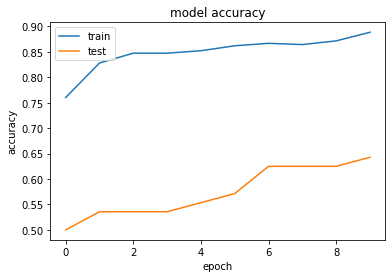

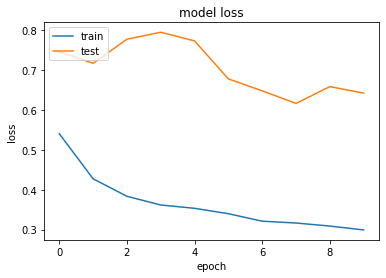

Epoch 1/10
52/52 [==============================] - 25s 398ms/step - loss: 0.6191 - accuracy: 0.7022 - val_loss: 0.7171 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 2/10
52/52 [==============================] - 17s 312ms/step - loss: 0.4488 - accuracy: 0.8087 - val_loss: 0.7427 - val_accuracy: 0.5536 - lr: 0.0010
Epoch 3/10
52/52 [==============================] - 19s 346ms/step - loss: 0.4008 - accuracy: 0.8354 - val_loss: 0.6841 - val_accuracy: 0.5893 - lr: 0.0010
Epoch 4/10
52/52 [==============================] - 15s 290ms/step - loss: 0.3738 - accuracy: 0.8475 - val_loss: 0.6649 - val_accuracy: 0.6071 - lr: 0.0010
Epoch 5/10
52/52 [==============================] - 16s 306ms/step - loss: 0.3578 - accuracy: 0.8547 - val_loss: 0.6884 - val_accuracy: 0.6071 - lr: 0.0010
Epoch 6/10
52/52 [==============================] - 18s 343ms/step - loss: 0.3442 - accuracy: 0.8523 - val_loss: 0.7163 - val_accuracy: 0.6071 - lr: 0.0010
Epoch 7/10
52/52 [==============================] - 16s 310ms/st

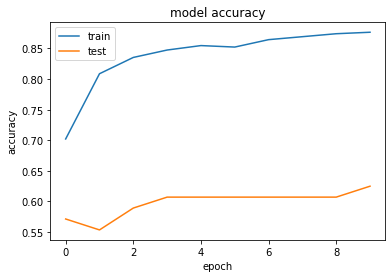

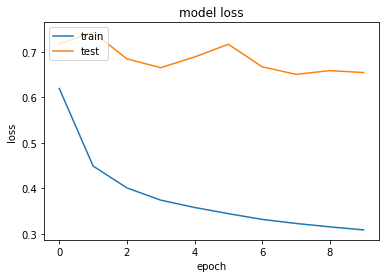

Epoch 1/10
52/52 [==============================] - 86s 2s/step - loss: 0.6174 - accuracy: 0.7191 - val_loss: 0.7268 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 2/10
52/52 [==============================] - 78s 2s/step - loss: 0.4533 - accuracy: 0.8087 - val_loss: 0.7648 - val_accuracy: 0.5357 - lr: 0.0010
Epoch 3/10
52/52 [==============================] - 78s 2s/step - loss: 0.4210 - accuracy: 0.8208 - val_loss: 0.6569 - val_accuracy: 0.5536 - lr: 0.0010
Epoch 4/10
52/52 [==============================] - 78s 1s/step - loss: 0.3993 - accuracy: 0.8160 - val_loss: 0.5902 - val_accuracy: 0.6607 - lr: 0.0010
Epoch 5/10
52/52 [==============================] - 80s 2s/step - loss: 0.3825 - accuracy: 0.8329 - val_loss: 0.6164 - val_accuracy: 0.6607 - lr: 0.0010
Epoch 6/10
52/52 [==============================] - 76s 1s/step - loss: 0.3710 - accuracy: 0.8329 - val_loss: 0.5505 - val_accuracy: 0.6786 - lr: 0.0010
Epoch 7/10
52/52 [==============================] - 80s 2s/step - loss: 0.3678 - a

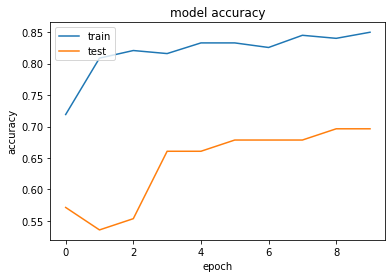

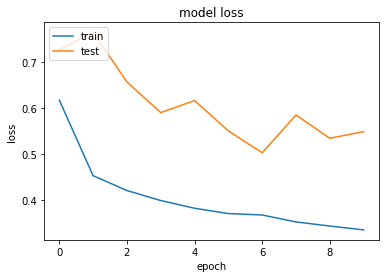

In [94]:
new_models = {}
for model_name, base_model in models:
    _, new_model = train(model_name, base_model)
    new_models[model_name] = new_model

In [95]:
!ls logs/*

logs/mobilenet-v3-large:
model_history.csv

logs/mobilenet-v3-small:
model_history.csv

logs/resnet50:
model_history.csv


In [96]:
# Amazing code from DTrimarchi10 obtained from https://github.com/DTrimarchi10/confusion_matrix allowing me to make a confusion matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

num_dom:  28 ; num_non_dom:  28
All models:  dict_keys(['mobilenet-v3-large', 'mobilenet-v3-small', 'resnet50'])
Evaluated model:  mobilenet-v3-large
1/1 [==============================] - 0s 213ms/step
Evaluated model:  mobilenet-v3-small
1/1 [==============================] - 0s 357ms/step
Evaluated model:  resnet50
1/1 [==============================] - 1s 1s/step


<Figure size 720x432 with 0 Axes>

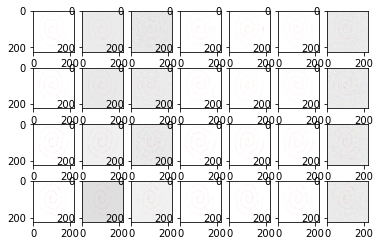

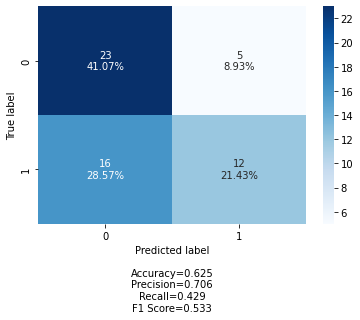

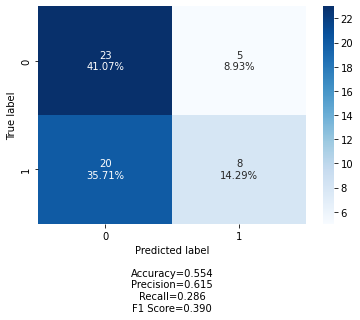

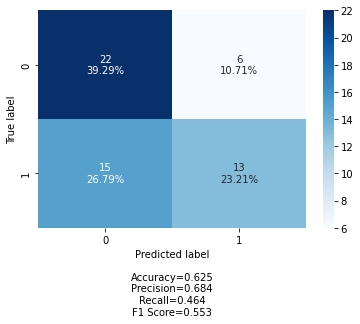

In [97]:
#Evaluating the model. Gotta check:
# - accuracy
# - precision ( True positive-TP / [TP + False positive-FP] )
# - recall ( TP / [TP + False negative-FN] )
# - F1score, if the ratio of positive and negatives in dataset are umbalanced?
# Also consider Area Under the Curve.
# We will use a validation dataset (dataset isolated from training process and used to measure performance of model)

eval_ds = val_ds #decides if we wanna see the performance on the "test" or "validation" dataset.

# Function that evaluates a given model's accuracy, precision, recall and F1score on our validation dataset
def evaluate_model(model):
  predictions = np.array([])
  labels =  np.array([])
  
  for x, y in eval_ds:
    threshold = tf.constant(0.5)
    prob_pred = tf.reshape(model.predict(x), [len(x)])
    binary_pred = tf.cast( (prob_pred>threshold), dtype=tf.float32)*1
    predictions = np.concatenate([predictions, binary_pred])
    labels = np.concatenate([labels, y])
  cm = confusion_matrix(labels, predictions)
  make_confusion_matrix(cm)

# Characteristic of validation dataset 
row, col = 2, 7
it = iter(eval_ds)
num_dom, num_non_dom = 0, 0
dom_img, non_dom_img = [], []

for imgs, labels in it:
  for i in range(len(imgs)):
    img, label = tf.cast(imgs[i], dtype=tf.int32), labels[i]
    if label == tf.constant(0):
      num_dom += 1
      if len(dom_img) < row*col:
        dom_img.append(img)
    else:
      num_non_dom += 1
      if len(non_dom_img) < row*col:
        non_dom_img.append(img)

all_img = dom_img + non_dom_img

plt.figure(figsize=(10,6))
f, axarr = plt.subplots(2*row, col)
for i in range(len(all_img)):
  axarr[i // 7][i % 7].imshow(all_img[i])

print("num_dom: ", num_dom, "; num_non_dom: ", num_non_dom)

# Actual evaluation
print("All models: ", new_models.keys())

for model_name in new_models.keys():
  print("Evaluated model: ", model_name)
  m = new_models[model_name]
  evaluate_model(m)